<a href="https://colab.research.google.com/github/RifatRudro/Data-Science-Work/blob/main/Classification_of_DNA_Sequence_Using_Hybrid_(CNN_%26_LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
#from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
DNA = pd.read_csv("/content/drive/MyDrive/SKRIPSI_Data_DM_DNA_Sequence.csv")
# see the sample from the dataset
DNA.head(20)

,sequence,length,class
0,AATAATTTGTGCACTTCAGAATATTCTACAATAATATATTATTTCC...,1010,DMT2
1,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1010,DMT2
2,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1013,DMT2
3,AGTTGGAGTCTCCAGGGATCAGGGTTCCAGGAACTCAGGATCTGCA...,1013,DMT2
4,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1015,DMT2
5,TGTGCACGCACCCTCTCCCTCATCCACCGCTGTCACCTCCTGCTGC...,1017,DMT2
6,TGTGCACGCACCCTCTCCCTCATCCACCGCTGTCACCTCCTGCTGC...,1017,DMT1
7,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1020,DMT2
8,ATTAATCCCCTGGCCCAACCCGTCATCTACTCTACCATCTTTGCAG...,1042,DMT2
9,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,1048,DMT2


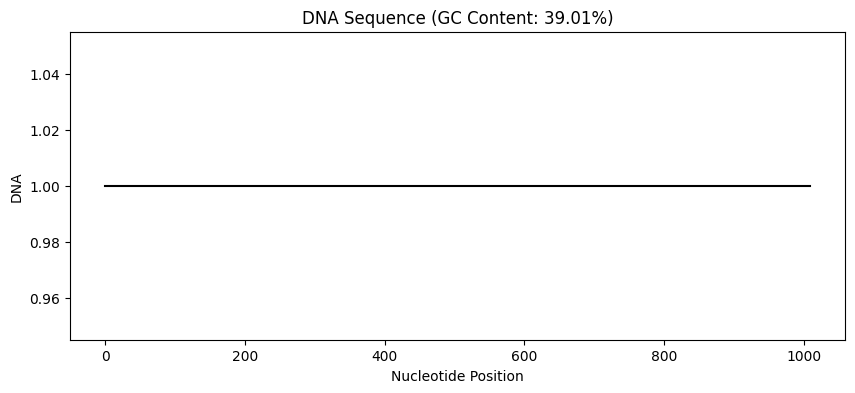

In [4]:
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio import SeqIO
import matplotlib.pyplot as plt

# Function to create a basic image of the DNA sequence
def visualize_dna_sequence(sequence):
    # Create a Seq object for working with the DNA
    my_seq = Seq(sequence)

    # Calculate GC content
    gc_content = GC(my_seq)

    # Create a basic plot (you can use more advanced libraries like seaborn or plotly for more complex plots)
    plt.figure(figsize=(10, 4))
    plt.plot(list(range(len(my_seq))), [1] * len(my_seq), color='black')
    plt.xlabel("Nucleotide Position")
    plt.ylabel("DNA")
    plt.title(f"DNA Sequence (GC Content: {gc_content:.2f}%)")
    plt.show()

# Example: visualize the first sequence in your dataset
first_sequence = DNA['sequence'][0]
visualize_dna_sequence(first_sequence)

In [6]:
class_distribution = DNA['class'].value_counts()
print("Class Distribution:")
print(class_distribution)

Class Distribution:
class
NONDM    989
DMT2     443
DMT1     145
Name: count, dtype: int64


In [7]:
colors = sns.color_palette("Dark2", len(DNA['class'].unique()))
colors

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254)]

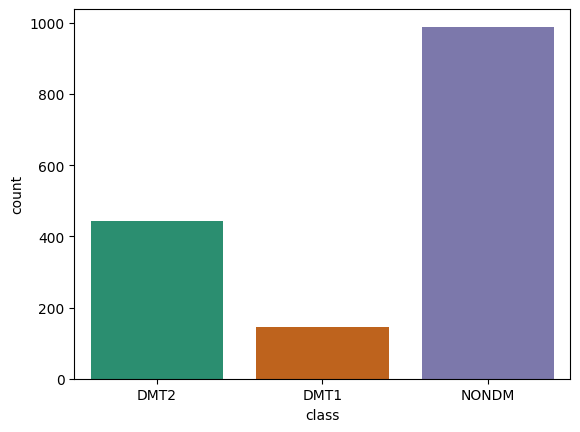

In [8]:
# shape of the dataset
DNA.shape
sns.countplot(DNA, x='class',palette=colors)
plt.show()

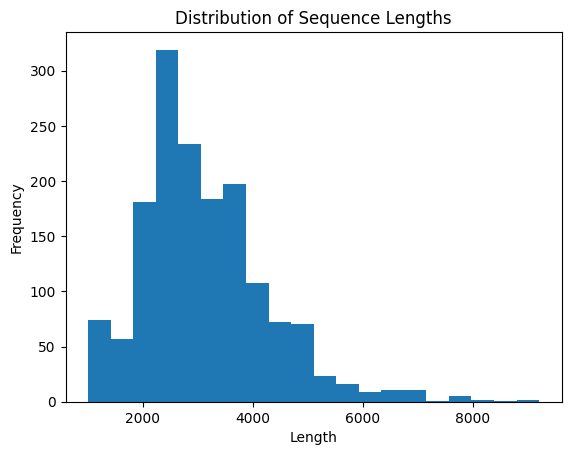

In [9]:
lengths = [len(seq) for seq in DNA['sequence']]
plt.hist(lengths,bins=20)
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

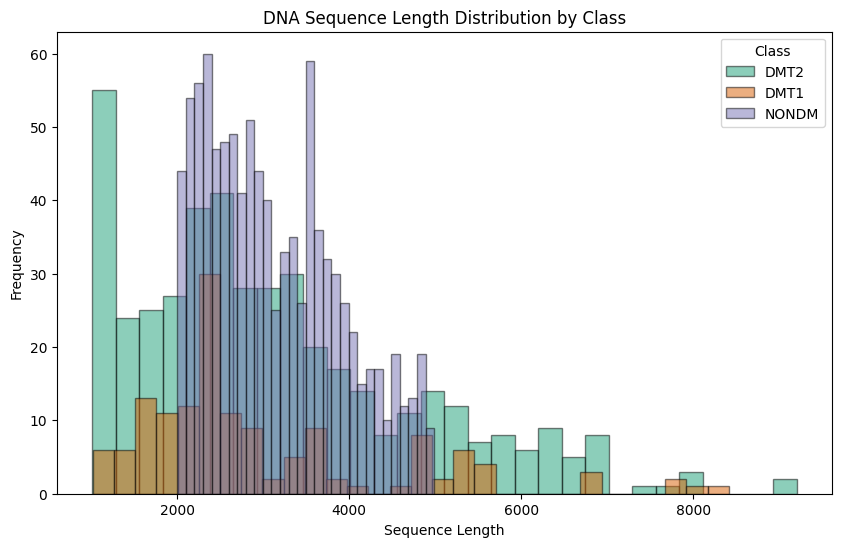

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate sequence lengths and add as a new column
DNA['sequence_length'] = DNA['sequence'].apply(len)

# Plot the distribution of sequence lengths for each class
plt.figure(figsize=(10, 6))

# Loop over each class to plot its length distribution
for i,class_label in enumerate(DNA['class'].unique()):
    # Filter rows by class and plot the length distribution
    class_lengths = DNA[DNA['class'] == class_label]['sequence_length']
    plt.hist(class_lengths, bins=30, alpha=0.5, label=class_label, edgecolor='black',color=colors[i])

# Add titles and labels
plt.title('DNA Sequence Length Distribution by Class')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend(title='Class')
plt.show()

In [11]:
# define k-mers function to split the sequence into group of k-mers words
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

# apply the k-mers function
DNA['k-mers'] = DNA.apply(lambda x: getKmers(x['sequence']), axis=1)
DNA[['sequence','k-mers']].head()

,sequence,k-mers
0,AATAATTTGTGCACTTCAGAATATTCTACAATAATATATTATTTCC...,"[aat, ata, taa, aat, att, ttt, ttg, tgt, gtg, ..."
1,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,"[agt, gtc, tcc, cct, ctt, ttc, tcg, cgc, gcc, ..."
2,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,"[agt, gtc, tcc, cct, ctt, ttc, tcg, cgc, gcc, ..."
3,AGTTGGAGTCTCCAGGGATCAGGGTTCCAGGAACTCAGGATCTGCA...,"[agt, gtt, ttg, tgg, gga, gag, agt, gtc, tct, ..."
4,AGTCCTTCGCCGTCCCTCGCCGTCCTTCGCCATCGCACGCCACCGC...,"[agt, gtc, tcc, cct, ctt, ttc, tcg, cgc, gcc, ..."


In [12]:
num_samples = DNA.shape[0]
k_mer_lengths = DNA['k-mers'].apply(len)

unique_k_mer_counts = k_mer_lengths.unique()

print(f"Number of samples: {num_samples}")
print(f"Unique k-mer lengths per sample: {unique_k_mer_counts}")
len(unique_k_mer_counts)

Number of samples: 1577
Unique k-mer lengths per sample: [1008 1011 1013 ... 8414 9030 9203]


1231

In [13]:
# DNA features
DNA_features = list(DNA['k-mers'])
for item in range(len(DNA_features)):
    DNA_features[item] = ' '.join(DNA_features[item]) # to remove "," between k mers and then save it all in same sequence


# DNA targets
DNA_targets = DNA['class'].copy()

In [14]:
lengths = [len(item) for item in DNA_features]
print(f"Lengths of each k-mer list: {lengths}")
print("________________________________________________")

# If you want to get unique lengths
unique_lengths = set(lengths)
print(f"Unique lengths of k-mer lists: {unique_lengths}")

Lengths of each k-mer list: [4031, 4031, 4043, 4043, 4051, 4059, 4059, 4071, 4159, 4183, 4211, 4227, 4231, 4247, 4255, 4263, 4291, 4291, 4303, 4319, 4351, 4351, 4355, 4379, 4399, 4415, 4415, 4431, 4479, 4543, 4543, 4603, 4619, 4655, 4667, 4667, 4687, 4703, 4711, 4727, 4747, 4763, 4763, 4839, 4843, 4863, 4875, 4891, 4911, 4915, 4927, 4927, 4955, 4963, 4999, 5015, 5019, 5059, 5083, 5099, 5123, 5227, 5275, 5319, 5367, 5427, 5479, 5511, 5639, 5643, 5643, 5655, 5655, 5667, 5671, 5715, 5715, 5759, 5779, 5787, 5935, 5991, 5991, 5995, 6027, 6031, 6123, 6123, 6135, 6147, 6159, 6191, 6215, 6235, 6299, 6299, 6327, 6395, 6419, 6467, 6503, 6515, 6515, 6519, 6527, 6543, 6567, 6595, 6607, 6643, 6643, 6679, 6679, 6679, 6719, 6739, 6751, 6751, 6891, 6899, 6923, 6939, 6963, 6967, 7015, 7023, 7035, 7203, 7207, 7251, 7251, 7311, 7311, 7323, 7411, 7415, 7439, 7479, 7539, 7555, 7559, 7563, 7599, 7611, 7635, 7655, 7663, 7775, 7775, 7787, 7811, 7835, 7839, 7843, 7847, 7883, 7899, 7915, 7979, 7995, 7999, 8007,

In [15]:
cv = TfidfVectorizer(ngram_range=(2,2))

DNA_features_CV = cv.fit_transform(DNA_features)

# samples
DNA_features_CV[0:5].toarray()

array([[0.13889097, 0.14847545, 0.07414369, ..., 0.04939782, 0.09892093,
        0.09936072],
       [0.        , 0.0123424 , 0.        , ..., 0.02463791, 0.04933831,
        0.08672591],
       [0.        , 0.02510029, 0.02506849, ..., 0.03757892, 0.06271096,
        0.08818567],
       [0.02518867, 0.03702444, 0.03697755, ..., 0.03695412, 0.03700099,
        0.08671948],
       [0.        , 0.02499872, 0.02496705, ..., 0.03742686, 0.0624572 ,
        0.08782883]])

In [16]:
DNA_features_CV.shape

(1577, 256)

In [17]:
DNA_features_dense = DNA_features_CV.toarray()

In [18]:
le = LabelEncoder()
DNA_targets = le.fit_transform(DNA_targets)
DNA_targets.shape

(1577,)

# **oversample**

In [19]:
sm = SMOTE(random_state=42, sampling_strategy='not majority')
DNA_features_oversampled, DNA_targets_oversampled = sm.fit_resample(DNA_features_dense, DNA_targets)

In [20]:
print(DNA_targets_oversampled.shape)
print(DNA_features_oversampled.shape)

(2967,)
(2967, 256)


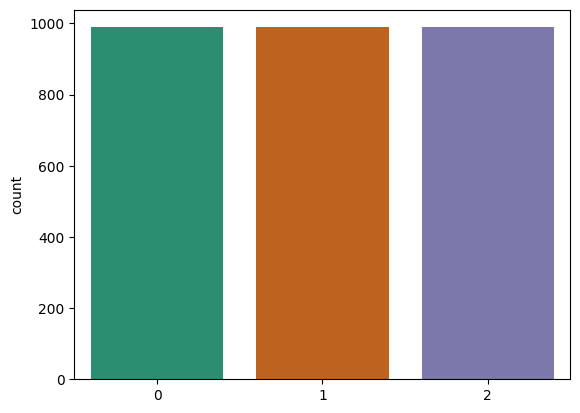

In [21]:
sns.countplot(x=DNA_targets_oversampled.squeeze(),palette=colors)


# Show the plot
plt.show()

In [22]:
selector = SelectKBest(f_classif, k=200)  # Select top 100 features
X_new = selector.fit_transform(DNA_features_oversampled, DNA_targets_oversampled)
X_new

array([[0.13889097, 0.14847545, 0.07414369, ..., 0.12499052, 0.09892093,
        0.09936072],
       [0.        , 0.0123424 , 0.        , ..., 0.03740455, 0.04933831,
        0.08672591],
       [0.        , 0.02510029, 0.02506849, ..., 0.03803414, 0.06271096,
        0.08818567],
       ...,
       [0.0177947 , 0.02413621, 0.02206768, ..., 0.00909908, 0.03196898,
        0.02275917],
       [0.        , 0.01202694, 0.00463945, ..., 0.03644854, 0.04807729,
        0.08450931],
       [0.22442637, 0.08633508, 0.12533633, ..., 0.10691781, 0.09772474,
        0.13834555]])

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_new, DNA_targets_oversampled, test_size=0.3, random_state=42, stratify=DNA_targets_oversampled
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (2076, 200)
Validation data shape: (594, 200)
Test data shape: (297, 200)


In [24]:
n_timesteps = 1


n_samples = X_train.shape[0]
n_features = X_train.shape[1] // n_timesteps


DNA_features_reshaped = X_train.reshape((n_samples, n_timesteps,n_features))

In [25]:
len(DNA_features_reshaped[0][0])

200

In [26]:
X_test_new = selector.fit_transform(X_test, y_test)
X_test_new.shape

(297, 200)

In [27]:
n_timesteps = 1
n_samples = X_test_new.shape[0]
n_features = X_test_new.shape[1] // n_timesteps


X_test_reshape = X_test_new.reshape((n_samples,n_timesteps, n_features))

In [28]:
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization

model = Sequential()

# Adjust input shape to (timesteps, features) for Conv1D
model.add(Conv1D(filters=512, kernel_size=1, activation='relu', input_shape=( 1,200)))  # Adjusted input shape
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Second convolutional layer
model.add(Conv1D(filters=256, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Adding an LSTM layer
model.add(LSTM(256, return_sequences=True))  # This LSTM expects a 3D input
model.add(Dropout(0.3))

# Adding another LSTM layer
model.add(LSTM(16))
model.add(Dropout(0.3))

# Dense layers for output
model.add(Dense(128, activation='gelu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 512)              │         102,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1, 256)              │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │          17,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │          66,048 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 848,320 (3.24 MB)

 Trainable params: 846,784 (3.23 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.3206 - loss: 5.7071 - val_accuracy: 0.4108 - val_loss: 1.1281
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.3599 - loss: 1.1744 - val_accuracy: 0.3333 - val_loss: 1.1061
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3852 - loss: 1.1065 - val_accuracy: 0.4613 - val_loss: 1.0560
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4959 - loss: 1.0206 - val_accuracy: 0.3502 - val_loss: 1.1500
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5711 - loss: 0.9343 - val_accuracy: 0.3973 - val_loss: 1.1162
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5628 - loss: 0.8975 - val_accuracy: 0.4141 - val_loss: 1.1730
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6055 - loss: 0.8274 - val_accuracy: 0.6162 - val_loss: 0.7361
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6025 - loss: 0.8439 - val_accuracy: 0

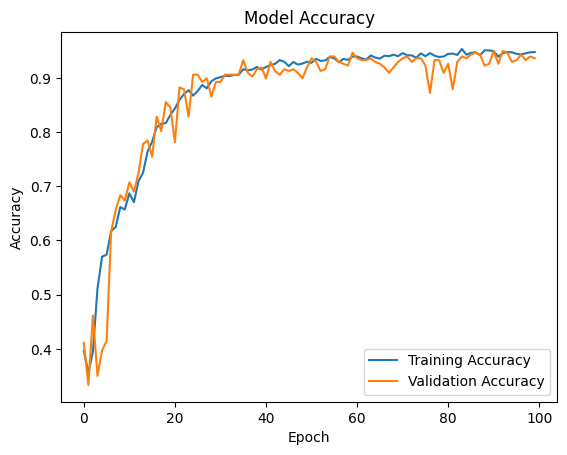

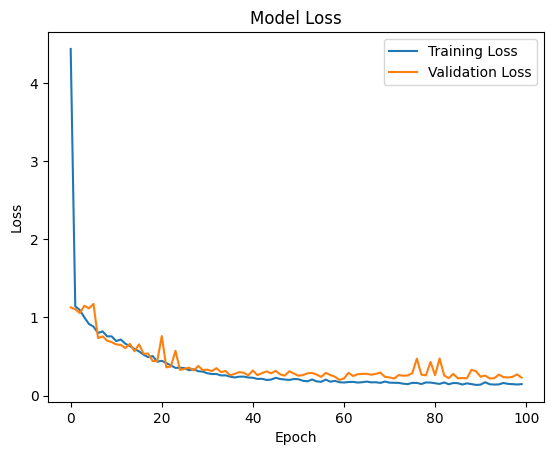

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        99
           1       0.93      0.91      0.92        99
           2       0.98      0.94      0.96        99

    accuracy                           0.94       297
   macro avg       0.94      0.94      0.94       297
weighted avg       0.94      0.94      0.94       297



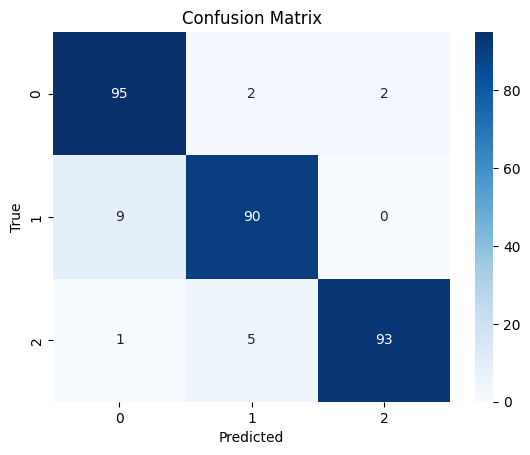

In [29]:
# Train the model
history = model.fit(DNA_features_reshaped, y_train, epochs=100, batch_size=32, validation_data=(X_test_reshape, y_test))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_reshape, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


y_pred_probs = model.predict(X_test_reshape)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [30]:
history = model.fit(DNA_features_reshaped, y_train,
                        epochs=50,
                        batch_size=32,
                        validation_split=0.3,
                        verbose=1)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9424 - loss: 0.1626 - val_accuracy: 0.9583 - val_loss: 0.1215
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9388 - loss: 0.1579 - val_accuracy: 0.9743 - val_loss: 0.0779
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9453 - loss: 0.1496 - val_accuracy: 0.9743 - val_loss: 0.0830
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9304 - loss: 0.1655 - val_accuracy: 0.9743 - val_loss: 0.0749
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9517 - loss: 0.1299 - val_accuracy: 0.9759 - val_loss: 0.0867
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9615 - loss: 0.1181 - val_accuracy: 0.9711 - val_loss: 0.0863
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9438 - loss: 0.1333 - val_accuracy: 0.9679 - val_loss: 0.0874
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9519 - loss: 0.1288 - val_accuracy: 0.9711 - v

In [31]:
predicted = model.predict(X_test_reshape)  # Get probabilities

# Convert probabilities to class labels
predicted_classes = np.argmax(predicted, axis=1)  # Get class labels

# Print classification report
print(classification_report(y_test, predicted_classes))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        99
           1       0.93      0.91      0.92        99
           2       1.00      0.94      0.97        99

    accuracy                           0.94       297
   macro avg       0.94      0.94      0.94       297
weighted avg       0.94      0.94      0.94       297

